In [15]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt

In [27]:
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
from dataclasses import dataclass
import ta
import pandas as pd
import numpy as np

@dataclass
class MyStrategySettings:
    position_size: float = 0.25
    trailing_stop: float = 0.04

class MyStrategy(Strategy):
    def __init__(self, settings: MyStrategySettings):
        super().__init__()
        self.settings = settings

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()
        
        cci_upper_threshold = 100
        cci_lower_threshold = -100

        data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], window=20)
        data['cci_buy'] = data['cci'] < cci_lower_threshold
        data['cci_sell'] = data['cci'] > cci_upper_threshold

        data['macd'] = ta.trend.macd(data['close'], window_fast=12, window_slow=26)
        data['macdsignal'] = ta.trend.macd_signal(data['close'], window_fast=12, window_slow=26, window_sign=9)
        data['macdhist'] = ta.trend.macd_diff(data['close'], window_fast=12, window_slow=26, window_sign=9)
        data['macdhist_last'] = data['macdhist'].shift(1)
        data['macdhist_last2'] = data['macdhist'].shift(2)
        data['macd_buy'] = (data['macdhist'] > data['macdhist_last']) & (data['macdhist_last'] > data['macdhist_last2'])
        data['macd_sell'] = (data['macdhist'] < data['macdhist_last']) & (data['macdhist_last'] < data['macdhist_last2'])

        # Define entry points based on CCI and MACD
        data['long_entry'] = (data['cci_buy']) & (data['macd_buy'])
        
        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, self.settings.position_size, self.settings.trailing_stop)
        
        # No need to implement exit logic as we're using trailing stop loss


In [28]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
train_since = datetime(2023, 12, 31, tzinfo=timezone.utc)
start_date = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2024, 6, 1, tzinfo=timezone.utc)
period = 168

feed = YFinanceFeed(interval = '1h')

In [29]:
settings = MyStrategySettings()
strategy = MyStrategy(settings)

# Create a Trader instance with the strategy
trader = Trader(SYMBOL, 1000, feed, strategy)

# Run the backtest
results = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)


Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£250.0) and 4.0% trail
    Creating MARKET BUY order for BTC-GBP at 33451.8203125 with quantity 0.0074435411189553635, trail 0.04, limit None, stop None
    Executing MARKET BUY order for BTC-GBP at 33451.8203125 with quantity 0.0074435411189553635, total cost £249.996 and transaction cost £0.996
        Bought 0.0074435411189553635 BTC-GBP at 33451.8203125 on 03/01/2024 18:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 33451.8203125 with quantity 0.0074435411189553635, trail 0.04, limit None, stop 32113.747499999998
    Updated trailing stop to 32290.364999999998
    Updated trailing stop to 32417.501249999998
    Updated trailing stop to 32538.716249999998
    Updated trailing stop to 32741.5575
    Updated trailing stop to 32745.45375
    Updated trailing stop to 32832.30375
    Updated trailing stop to 32904.12375
    Updated trailing stop to 33042.69375
    Updated t

In [30]:
# Set display options
pd.set_option('display.max_rows', None)  # Adjust None to your specific needs
pd.set_option('display.max_columns', None)  # Adjust None as needed
pd.set_option('display.width', 1000)  # Adjust the width to fit your notebook

print('win rate: ', results['win_rate'])

display(results['returns'])

# Display the results
# Filter the history DataFrame to show only rows with True in open_long or close_long columns
filtered_history = results['history'][(results['history']['open_long'] == True) | (results['history']['close_long'] == True)]

# Display the filtered results
display(filtered_history)

display(results['orders'])


win rate:  0.3181818181818182


,start_date,end_date,price_start,price_end,valuation_start,valuation_end,asset_return,portfolio_return
0,2024-01-01 00:00:00+00:00,2024-01-02 00:00:00+00:00,33201.246094,35381.070312,1000.000000,1000.000000,0.065655,0.000000
1,2024-01-02 00:00:00+00:00,2024-01-03 00:00:00+00:00,35381.070312,35744.773438,1000.000000,1000.000000,0.010280,0.000000
2,2024-01-03 00:00:00+00:00,2024-01-04 00:00:00+00:00,35744.773438,33855.203125,1000.000000,1002.006597,-0.052863,0.002007
3,2024-01-04 00:00:00+00:00,2024-01-05 00:00:00+00:00,33855.203125,34872.585938,1002.006597,1009.579527,0.030051,0.007558
4,2024-01-05 00:00:00+00:00,2024-01-06 00:00:00+00:00,34872.585938,34663.414062,1009.579527,1008.022548,-0.005998,-0.001542
5,2024-01-06 00:00:00+00:00,2024-01-07 00:00:00+00:00,34663.414062,34711.617188,1008.022548,1008.381350,0.001391,0.000356
6,2024-01-07 00:00:00+00:00,2024-01-08 00:00:00+00:00,34711.617188,34360.316406,1008.381350,1005.766428,-0.010121,-0.002593
7,2024-01-08 00:00:00+00:00,2024-01-09 00:00:00+00:00,34360.316406,36644.847656,1005.766428,1022.771430,0.066487,0.016908
8,2024-01-09 00:00:00+00:00,2024-01-10 00:00:00+00:00,36644.847656,36068.718750,1022.771430,1018.482991,-0.015722,-0.004193
9,2024-01-10 00:00:00+00:00,2024-01-11 00:00:00+00:00,36068.718750,36613.890625,1018.482991,1012.769723,0.015115,-0.005610


,open,high,low,close,volume,Dividends,Stock Splits,open_long,close_long
date,,,,,,,,,
2024-01-03 18:00:00+00:00,33883.417969,34032.816406,33444.277344,33451.820312,396267520,0.0,0.0,True,False
2024-01-10 12:00:00+00:00,35810.656250,35856.500000,35030.187500,35138.976562,438306816,0.0,0.0,False,True
2024-01-12 20:00:00+00:00,34056.820312,34493.980469,34041.558594,34342.449219,95002624,0.0,0.0,True,False
2024-01-14 23:00:00+00:00,33158.679688,33158.679688,32761.166016,32828.097656,1171092480,0.0,0.0,False,True
2024-01-15 01:00:00+00:00,33171.894531,33256.785156,33110.851562,33164.042969,283255808,0.0,0.0,True,False
2024-01-18 16:00:00+00:00,33581.359375,33592.167969,32894.117188,32980.074219,757159936,0.0,0.0,False,True
2024-01-18 22:00:00+00:00,32364.375000,32518.304688,32364.375000,32516.716797,274159616,0.0,0.0,True,False
2024-01-22 19:00:00+00:00,31688.203125,31844.535156,31055.132812,31289.183594,2726287360,0.0,0.0,False,True
2024-01-23 01:00:00+00:00,31299.488281,31361.619141,31222.123047,31287.037109,0,0.0,0.0,True,False


{'c38a6be2-65b7-4dcb-a9a7-0f52371632d1': Order(symbol='BTC-GBP', order_type='MARKET', order_side='BUY', quantity=0.0074435411189553635, trail=0.04, limit=None, stop=None, id='c38a6be2-65b7-4dcb-a9a7-0f52371632d1', timestamp=Timestamp('2024-01-03 18:00:00+0000', tz='UTC'), status='FILLED', trades=[Trade(id='f035d4a9-e97f-4f89-afdb-de3fb8c27646', order_id='c38a6be2-65b7-4dcb-a9a7-0f52371632d1', symbol='BTC-GBP', order_type='MARKET', order_side='BUY', price=33451.8203125, quantity=0.0074435411189553635, timestamp=Timestamp('2024-01-03 18:00:00+0000', tz='UTC'), transaction_costs=0.996)]),
 'd5ec1126-cf20-4ded-8360-6cbe741d3b57': Order(symbol='BTC-GBP', order_type='TRAILING_STOP', order_side='SELL', quantity=0.0074435411189553635, trail=0.04, limit=None, stop=35476.7175, id='d5ec1126-cf20-4ded-8360-6cbe741d3b57', timestamp=Timestamp('2024-01-03 18:00:00+0000', tz='UTC'), status='FILLED', trades=[Trade(id='478b377a-23ee-4a1a-b57c-1b08f90d042f', order_id='d5ec1126-cf20-4ded-8360-6cbe741d3b57

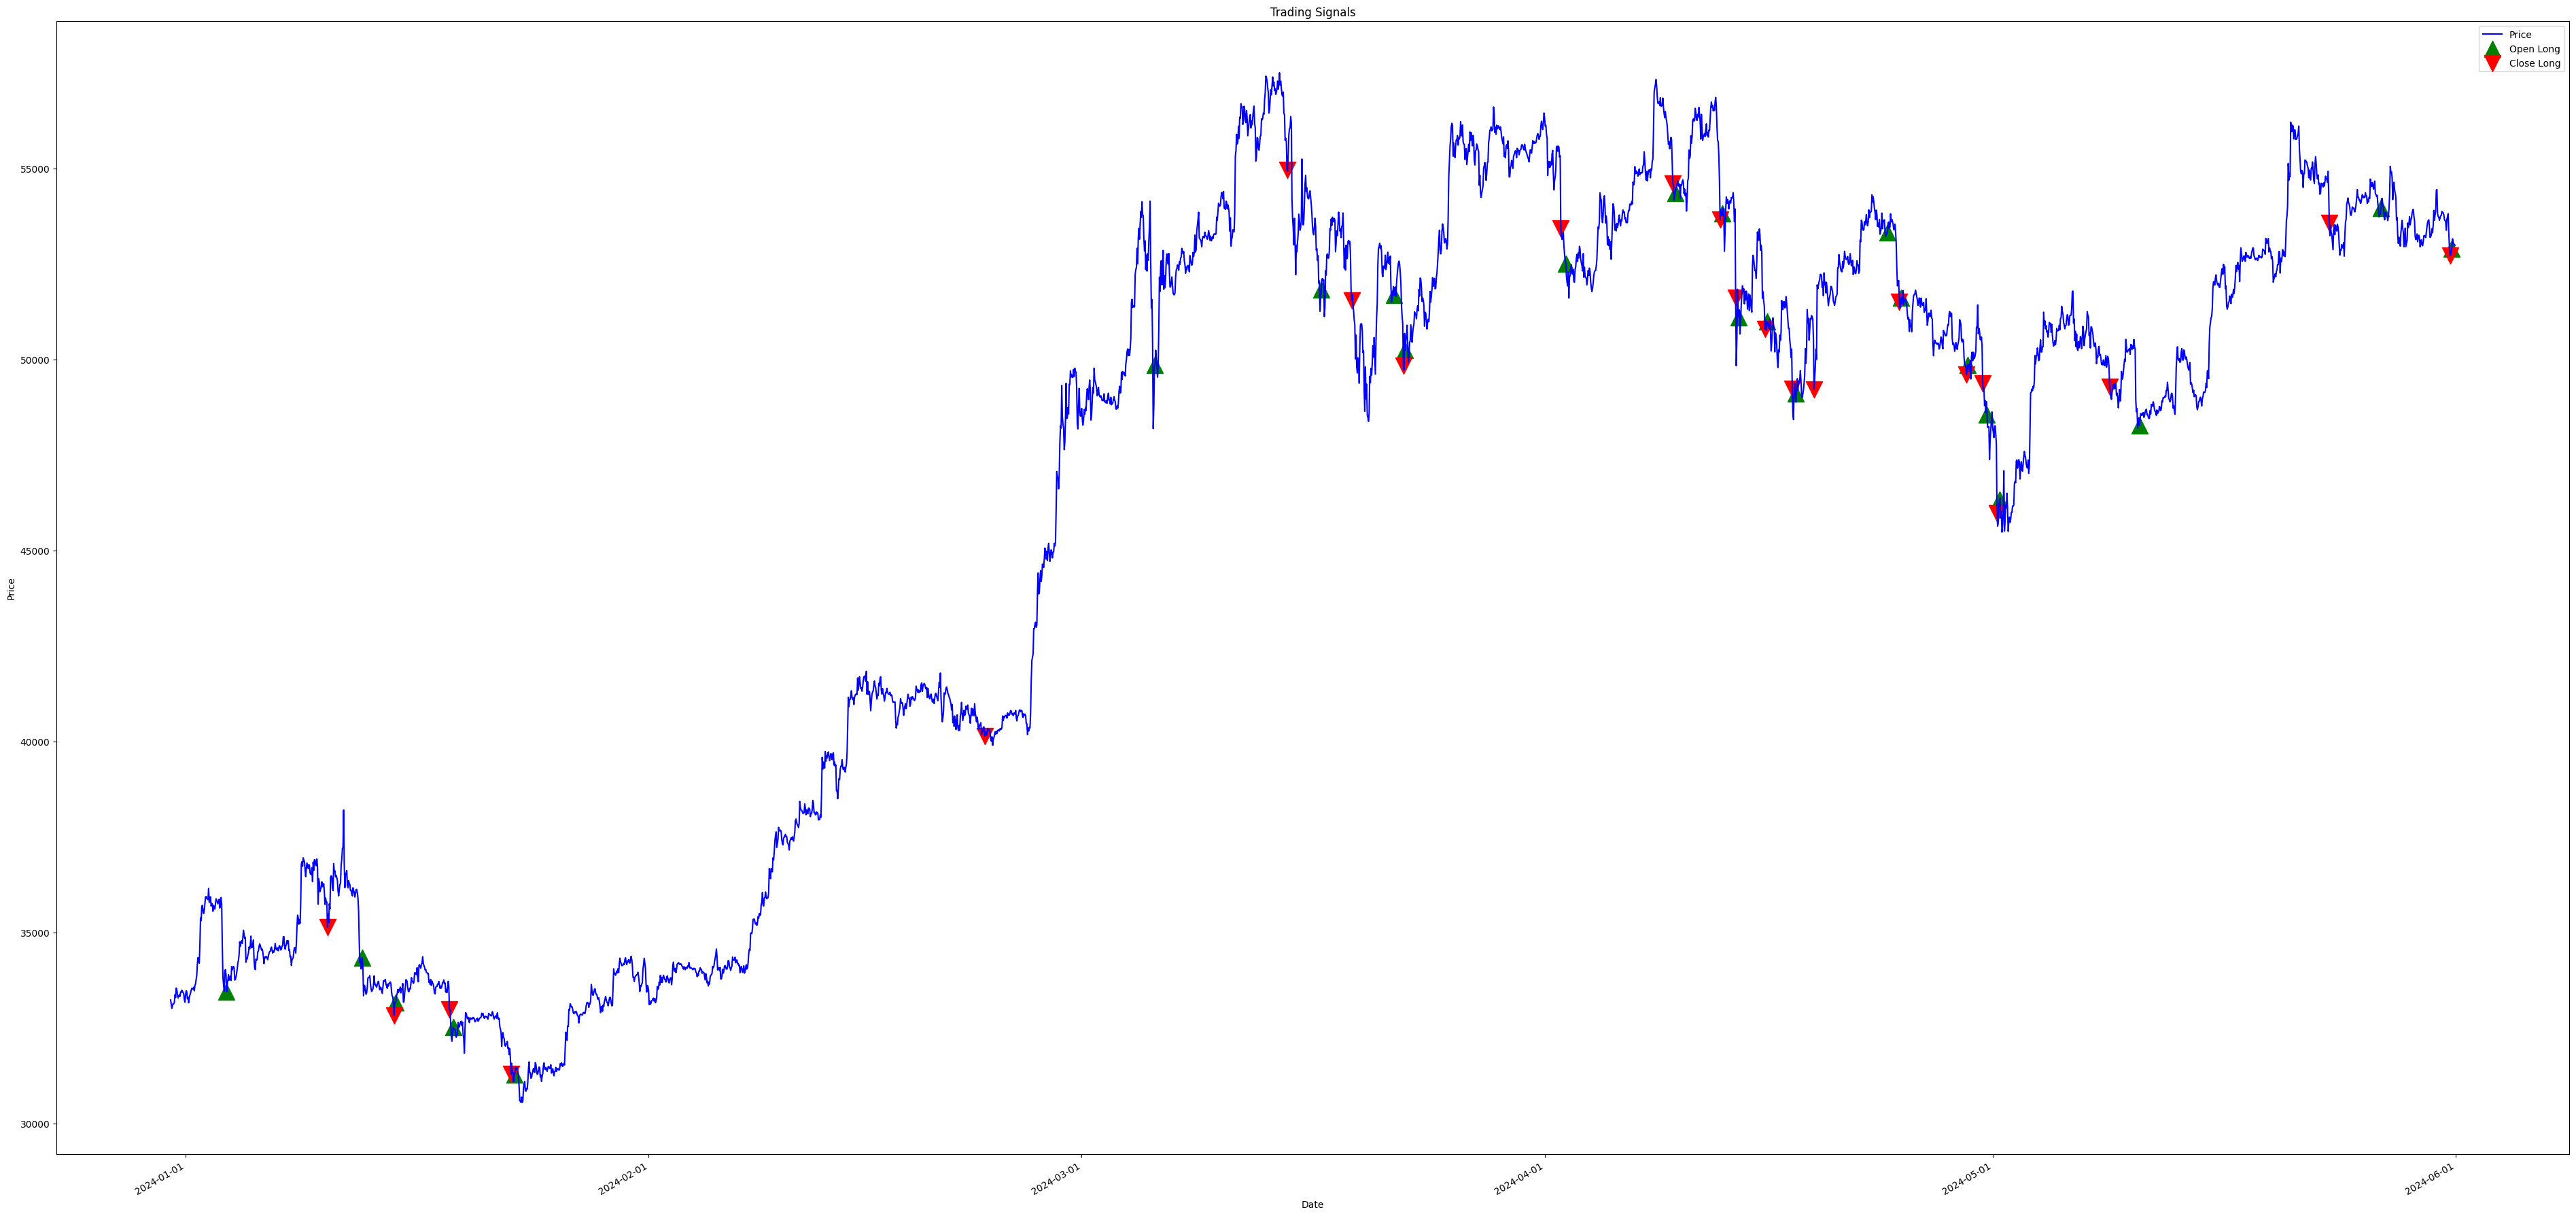

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the index to datetime if it's not already
results['history'].index = pd.to_datetime(results['history'].index)

# Create the plot
fig, ax = plt.subplots(figsize=(38, 18))

# Plot the price
ax.plot(results['history'].index, results['history']['close'], color='blue', label='Price')

# Plot green arrows for open_long
open_long = results['history'][results['history']['open_long']]
ax.scatter(open_long.index, open_long['close'], color='green', marker='^', s=300, label='Open Long')

# Plot red arrows for close_long
close_long = results['history'][results['history']['close_long']]
ax.scatter(close_long.index, close_long['close'], color='red', marker='v', s=300, label='Close Long')

# Customize the plot
ax.set_title('Trading Signals')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()
plt.show()
